In [1]:
import numpy as np 
import pandas as pd 
import os
#To check for the load of images
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

## Importing libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,InputLayer,Input,Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.regularizers import L1,L2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


2024-04-23 17:35:17.841460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 17:35:17.841563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 17:35:17.972870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Given the predictions of a model, it checks if the true label is within the top-K predicted labels. If it is, then it counts it as a correct prediction. This metric is particularly useful in scenarios where you are interested in considering predictions that are within the top-K most probable classes.

In [3]:
directory  = '/kaggle/input/satellite-image-classification/data'
class_name = ["cloudy","desert","green_area","water"]#given there are 4 classes in the given dataset

## Data Preprocessing

In [4]:
dataset =tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',#This parameter specifies the format of the labels. 'categorical' indicates that the labels are one-hot encoded.
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 5631 files belonging to 4 classes.


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)  # Rescaling pixel values between 0 and 1
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

# Visualize some data

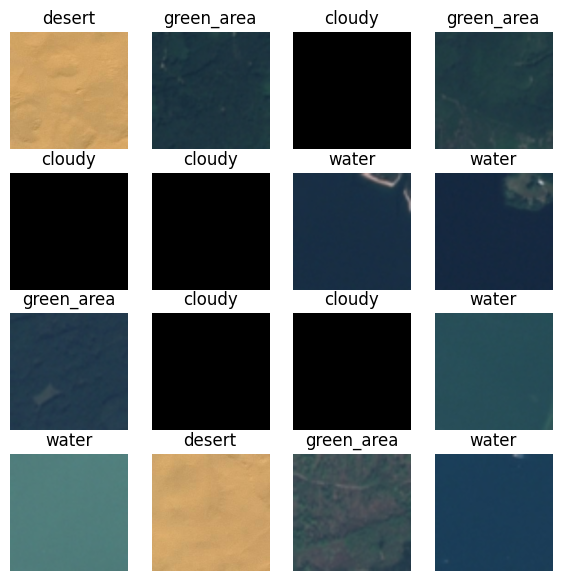

In [11]:
plt.figure(figsize = (7,7))
for images, labels in dataset.take(7):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i])
    plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [47]:
def splits(dataset, Train_ratio, Val_ratio, Test_ratio):
    Data_size = len(dataset)
    train_size = int(Train_ratio * Data_size)
    val_size = int(Val_ratio * Data_size)
    # Splitting the dataset into training, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
    return train_dataset, val_dataset, test_dataset


In [56]:
Train_ratio =0.80
Val_ratio = 0.10
Test_ratio =0.10

train_dataset,val_dataset,test_dataset = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

# Lenet Model 

### Comprising convolutional layers, pooling layers, and fully connected layers, it extracts hierarchical features, enabling efficient pattern recognition. LeNet's design laid the groundwork for modern CNNs, revolutionizing image recognition and deep learning.LeNet consists of convolutional layers for feature extraction, followed by pooling layers for dimensionality reduction. It alternates these layers, gradually capturing intricate features. Fully connected layers then classify the extracted features. LeNet typically includes 2 convolutional layers, 2 pooling layers, and 3 fully connected layers, culminating in softmax output.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 252, 252, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 126, 126, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,157,816 (27.30 MB)

 Trainable params: 7,157,816 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
  5/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3589 - loss: 1.3231

W0000 00:00:1713791965.594445      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7618 - loss: 0.5330

W0000 00:00:1713791972.826691      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7627 - loss: 0.5307 - val_accuracy: 0.9062 - val_loss: 0.2093
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8742 - loss: 0.2729 - val_accuracy: 0.8915 - val_loss: 0.2365
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9099 - loss: 0.2102 - val_accuracy: 0.9026 - val_loss: 0.2118
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9029 - loss: 0.2161 - val_accuracy: 0.9173 - val_loss: 0.1756
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9111 - loss: 0.1967 - val_accuracy: 0.8860 - val_loss: 0.1987
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9159 - loss: 0.1789 - val_accuracy: 0.9412 - val_loss: 0.1525
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9232 - loss: 0.1657 - val_accuracy: 0.8566 - val_loss: 0.2323
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9000 - loss: 0.2172 - val_accuracy: 0.94

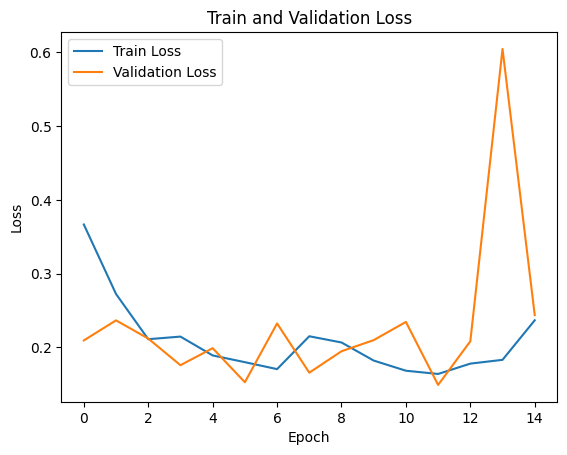

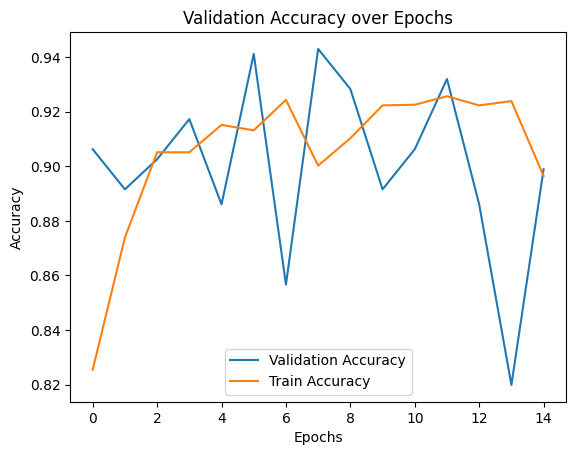

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


W0000 00:00:1713792083.284991      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
y_pred size 607


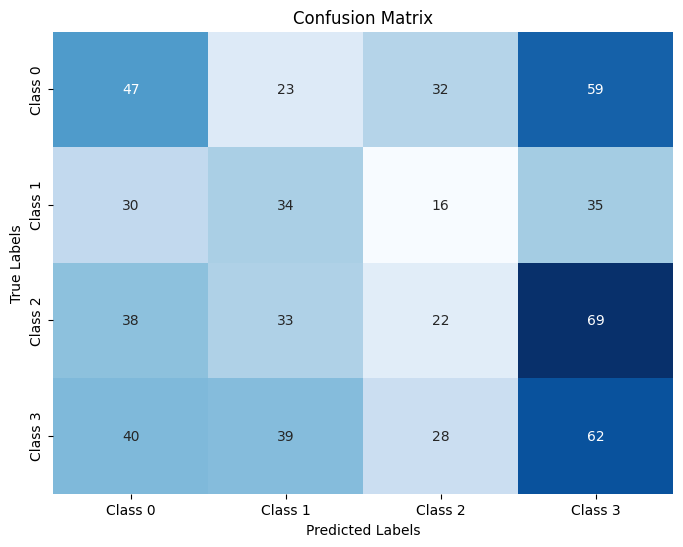

In [57]:
def build_lenet5(input_shape):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 output classes
    return model

input_shape = (256, 256, 3)
lenet5_model = build_lenet5(input_shape)
lenet5_model.summary()
lenet5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lenet5_model.fit(train_dataset, validation_data=val_dataset, epochs=15)
val_loss, val_accuracy = lenet5_model.evaluate(val_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
# Plotting train loss and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


# Plotting validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()
# Predict labels for test dataset
y_pred = []
for batch in test_dataset:
    batch_predictions = np.argmax(lenet5_model.predict(batch[0]), axis=-1)
    y_pred.extend(batch_predictions)

# Convert to numpy array
y_pred = np.array(y_pred)
print("y_pred size",y_pred.size)
# Get true labels for test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=-1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [58]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(true_labels, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.27182866556836904
Precision: 0.2669945110144216
Recall: 0.27182866556836904
F1 Score: 0.2644889411292057


In [14]:
from tensorflow.keras.applications import VGG16

In [15]:
VGG_backbone = VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(256,256,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
VGG_16_Model = tf.keras.Sequential([
         Input(shape=(256,256,3)),
         VGG_backbone,
         GlobalAveragePooling2D(),
     
       
         Dense(1024, activation='relu'),
         BatchNormalization(),
    
         Dense(128, activation='relu'),
         
         Dense(4, activation = 'softmax')
])
VGG_16_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,375,812 (58.65 MB)

 Trainable params: 15,373,764 (58.65 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [17]:
VGG_16_Model.compile(loss=categorical_crossentropy,
                   optimizer = Adam(learning_rate=0.01),
                   metrics=metrics)

In [18]:
History_2 = VGG_16_Model.fit(train_dataset,validation_data=val_dataset,epochs=2,verbose=1)

Epoch 1/2


2024-04-20 16:42:07.337542: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-20 16:42:10.576980: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.239544556s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-20 16:42:14.918188: E external/

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6571 - loss: 1.1041 - top_k_accuracy: 0.9348

W0000 00:00:1713631443.537836      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 205s 517ms/step - accuracy: 0.6575 - loss: 1.1013 - top_k_accuracy: 0.9350 - val_accuracy: 0.2408 - val_loss: 3.3278 - val_top_k_accuracy: 0.5092
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 505ms/step - accuracy: 0.7385 - loss: 0.5371 - top_k_accuracy: 0.9847 - val_accuracy: 0.2812 - val_loss: 503.3278 - val_top_k_accuracy: 0.7408


# Resnet50

In [19]:
from tensorflow.keras.applications import ResNet50 

In [20]:
Resnet_50_backbone = ResNet50(
             include_top=False,
             weights='imagenet',
             input_shape=(256,256,3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
Resnet_50_Model = tf.keras.Sequential([
         Input(shape=(256,256,3)),
         Resnet_50_backbone,
         GlobalAveragePooling2D(),
     
       
         Dense(1024, activation='relu'),
         BatchNormalization(),
    
         Dense(128, activation='relu'),
         
         Dense(4, activation = 'softmax')
])
Resnet_50_Model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,821,700 (98.50 MB)

 Trainable params: 25,766,532 (98.29 MB)

 Non-trainable params: 55,168 (215.50 KB)

In [22]:
Resnet_50_Model.compile(loss=categorical_crossentropy,
                   optimizer = Adam(learning_rate=0.01),
                   metrics=metrics)

In [23]:
History_3 = Resnet_50_Model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5


W0000 00:00:1713631597.243621      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6029 - loss: 0.7221 - top_k_accuracy: 0.8943

W0000 00:00:1713631648.752888      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 131s 380ms/step - accuracy: 0.6035 - loss: 0.7211 - top_k_accuracy: 0.8947 - val_accuracy: 0.2261 - val_loss: 78091.0859 - val_top_k_accuracy: 0.7757
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 348ms/step - accuracy: 0.7649 - loss: 0.4138 - top_k_accuracy: 0.9968 - val_accuracy: 0.4632 - val_loss: 2.4147 - val_top_k_accuracy: 0.7335
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 348ms/step - accuracy: 0.7621 - loss: 0.4600 - top_k_accuracy: 0.9887 - val_accuracy: 0.4945 - val_loss: 5.9663 - val_top_k_accuracy: 0.7518
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 359ms/step - accuracy: 0.8297 - loss: 0.3533 - top_k_accuracy: 0.9978 - val_accuracy: 0.8474 - val_loss: 15.6231 - val_top_k_accuracy: 0.9926
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.7935 - loss: 2.0506 - top_k_accuracy: 0.9826 - val_accuracy: 0.2518 - val_loss: 51750.1562 - val_top_k_accuracy: 1.0000


# EfficientNET

In [24]:
main_component = tf.keras.applications.efficientnet.EfficientNetB2(
                             include_top=False,
                             weights='imagenet',
                             input_shape=(256,256,3)
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
EfficientNet_Model = tf.keras.Sequential([
         Input(shape=(256,256,3)),
         main_component,
         GlobalAveragePooling2D(),
     
       
         Dense(1024, activation='relu'),
         BatchNormalization(),
    
         Dense(128, activation='relu'),
         
         Dense(4, activation = 'softmax')
])
EfficientNet_Model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 8, 8, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,347,197 (35.66 MB)

 Trainable params: 9,277,574 (35.39 MB)

 Non-trainable params: 69,623 (271.97 KB)

In [27]:
EfficientNet_Model.compile(loss=categorical_crossentropy,
                   optimizer = Adam(learning_rate=0.01),
                   metrics=metrics)

In [28]:
History_4 = EfficientNet_Model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5


W0000 00:00:1713632019.037394      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4943 - loss: 2.5045 - top_k_accuracy: 0.8807

W0000 00:00:1713632063.354083      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 194s 325ms/step - accuracy: 0.4950 - loss: 2.4967 - top_k_accuracy: 0.8809 - val_accuracy: 0.4651 - val_loss: 388.8358 - val_top_k_accuracy: 1.0000
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 37s 263ms/step - accuracy: 0.7251 - loss: 0.4757 - top_k_accuracy: 0.9884 - val_accuracy: 0.3787 - val_loss: 1.3351 - val_top_k_accuracy: 0.9706
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.9076 - loss: 0.2690 - top_k_accuracy: 0.9942 - val_accuracy: 0.6544 - val_loss: 0.6970 - val_top_k_accuracy: 0.9485
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 37s 263ms/step - accuracy: 0.9597 - loss: 0.1262 - top_k_accuracy: 0.9952 - val_accuracy: 0.8474 - val_loss: 0.5987 - val_top_k_accuracy: 1.0000
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.8564 - loss: 0.3198 - top_k_accuracy: 0.9908 - val_accuracy: 0.7169 - val_loss: 0.6555 - val_top_k_accuracy: 1.0000
